In [5]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [6]:
env = BlackjackEnv()

In [7]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [8]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        action_rewards = Q[observation]
        prob = np.zeros(len(action_rewards), dtype=float)
        prob[np.argmax(action_rewards)] = 1.0
        return prob

    return policy_fn

In [22]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episode in range(num_episodes):
        print('\rEpisode {}/{}'.format(i_episode, num_episodes), end='')
        
        # Run episodes and save tuples of (state, action, reward)
        # for every timestep t
        episode = []
        state = env.reset()
        while True:
            prob = behavior_policy(state)
            action = np.random.multinomial(1, prob).argmax()
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            
            if done:
                break
                
            state = next_state
            
        # This method is different from the previous because the policy
        # used to evaluate the value is an exploratory policy called
        # the behavior policy. This allows the target policy to be greedy
        # as opposed to epsilon-greedy.
        
        # The behavior policy must have a non-zero probability of choosing
        # all actions. This is coverage. All that is needed is a way of
        # estimating the Value of the target_policy while using the 
        # behavior_policy. To do this we scale the value by the relative
        # probability of the trajectory under the and behavior policies.
        
        # Incremental implementation of weighted importance sampling.
        
        G = 0.0
        W = 1.0
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            
            G = discount_factor * G + reward
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            
            true_action = target_policy(state).argmax()
            if action != true_action:
                break
                
            W = W * 1 / behavior_policy(state)[action]
            
    return Q, target_policy

In [23]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 499999/500000

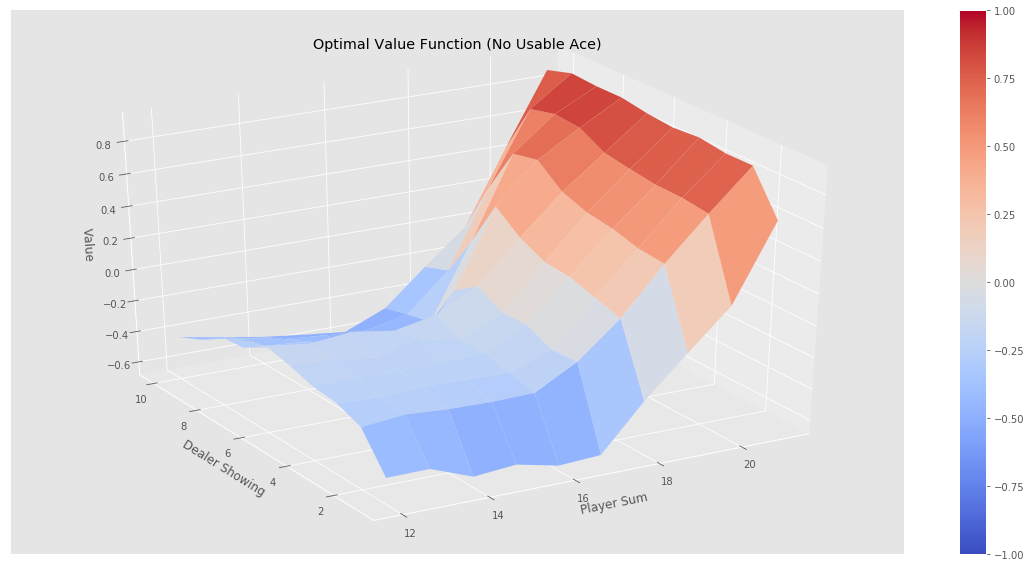

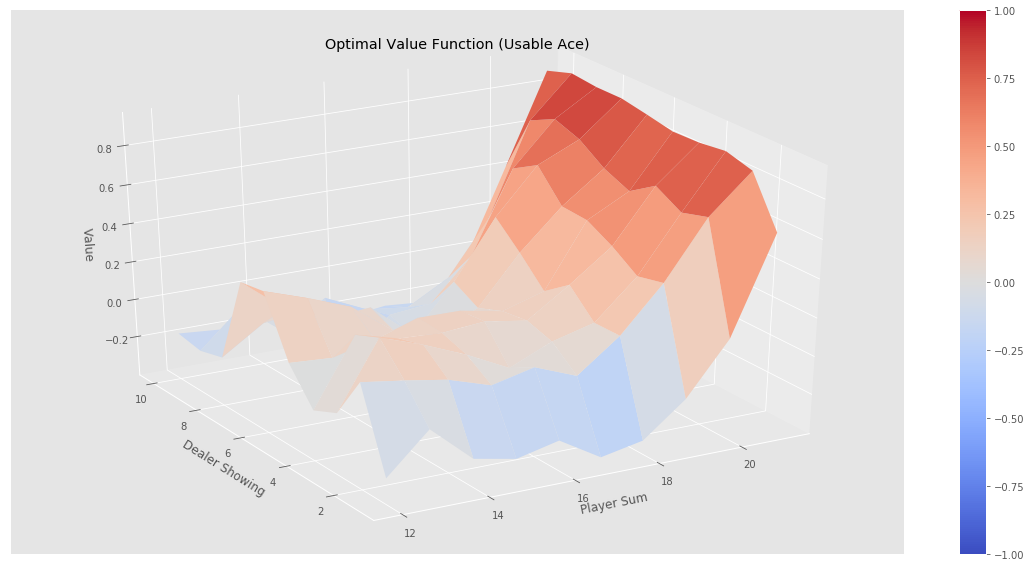

In [24]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")